In [5]:
import fnmatch
import os
import pathlib
import random
import time

import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import numpy as np
import psutil
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm

sns.set_theme(style="whitegrid", palette="husl")

In [6]:
model_name = "resnet18_3Class_RN_FT_True_Epochs30"
model_read = torch.jit.load(f"models/{model_name}.pt")

# model_name = "resnet18_3ClassNewZeros"
# model_read = torch.jit.load(f"models/{model_name}.pt")

# model_name = "resnet18-Gold20220530.full"
# model_read = torch.load(f"models/{model_name}.pt")

model_read.eval()

RecursiveScriptModule(
  original_name=DinosourBoneFinder
  (network): RecursiveScriptModule(
    original_name=ResNet
    (conv1): RecursiveScriptModule(original_name=_IPEXConv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=_IPEXConv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (conv2): RecursiveScriptModule(original_name=_IPEXConv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      )
      (1): RecursiveScriptModule(
        original_name=BasicBlock
        (conv1): RecursiveScriptModule(original_name=_IPEXConv2d)
        (bn1): RecursiveScriptModule(original_nam

In [7]:
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

class ImageFolderWithPaths(datasets.ImageFolder):
    """custom ImageFolder to get the filepaths along with the image and label data."""

    def __getitem__(self, index):
        paths = ((self.imgs[index][0]),)
        return super().__getitem__(index) + paths


def infer(model, data_path: str):
    """give trained `model` & `data_path` where images whose
    labels have to be predicted are kept.

    `data_path`: path to data eg. ./test/<random_class>/*.png
    it's important to have a folder with a`random class` name as ImgFolder
    expects it.

    returns: (
        images: images loaded from disk for inferece,
        yhats: predicted labels
        paths: image file-path on disk        )
    """
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(*imagenet_stats)]
    )
    data = ImageFolderWithPaths(data_path, transform=transform)
    dataloader = DataLoader(
        data,
        batch_size=4,
    )
    yhats = []
    images = []
    paths = []
    for (imgs, _, fpaths) in dataloader:
        yhat = model(imgs)
        yhat = yhat.max(1)[1]
        yhat = yhat.data.cpu().numpy()
        yhats.extend(yhat)
        paths.extend(fpaths)
        images.extend(imgs.data.cpu())
    return images, yhats, paths

def show_data(dataloader, imagenet_stats=imagenet_stats, num_data=4, figsize=(10, 6)):
    """show `num_data` of images and labels from dataloader."""
    batch = next(iter(dataloader))  # batch of with images, batch of labels
    imgs, labels = (
        batch[0][:num_data],
        batch[1][:num_data].tolist(),
    )  # get num_data of images, labels
    plt.style.use("dark_background")
    _, axes = plt.subplots(1, num_data, figsize=figsize)
    for n in range(num_data):
        axes[n].set_title(labels[n])
        imgs[n] = _denormalize(imgs[n], imagenet_stats)
        axes[n].imshow(torch.clamp(imgs[n], 0, 1).permute(1, 2, 0))

def _denormalize(images, imagenet_stats):
    """de normalize dataset using imagenet std and mean to show images"""
    mean = torch.tensor(imagenet_stats[0]).reshape(1, 3, 1, 1)
    std = torch.tensor(imagenet_stats[1]).reshape(1, 3, 1, 1)
    return images * std + mean

In [8]:
!mkdir data/ThreeClassManualRemove0s/test
!mkdir  data/ThreeClassManualRemove0s/test/unknown
!cp data/DinosaurNationalMonument/20220514/224/*.jpg data/ThreeClassManualRemove0s/test/unknown/

mkdir: cannot create directory ‘data/ThreeClassManualRemove0s/test’: File exists
mkdir: cannot create directory ‘data/ThreeClassManualRemove0s/test/unknown’: File exists


infered images with labels


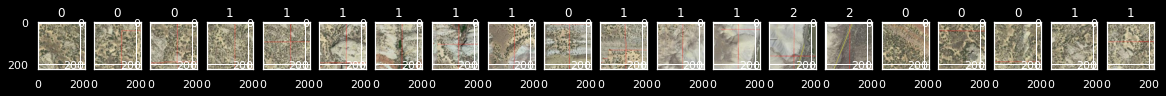

In [9]:
imagenet_stats = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
images, yhats, img_paths = infer(
    model_read, data_path="./data/ThreeClassManualRemove0s/test/"
)
infer_dataloader = DataLoader([*zip(images, yhats)], batch_size=100, shuffle=False)
print("infered images with labels")
show_data(infer_dataloader, imagenet_stats, 20, figsize=(20, 16))


# Inference Given Large Image

In [10]:
import glob
from PIL import Image
from os.path import exists
import os
path = "data/DinosaurNationalMonument/Dinosaur National Monument Panorama.png"
#path = "data/Pombal/Pombal01.PNG"
path = "data/Bob/BobTest.PNG"
img = Image.open(path).convert('RGB')
img.size

(1915, 1050)

# Get sample near DNM Excavation

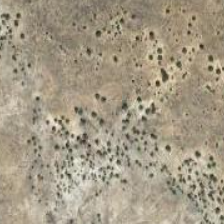

In [11]:
# left = 4*224+112
# low = 4*224+112
left = 2*224
low = 1*224
bbox = (left, low, left + 224, low + 224)
working_slice = img.crop(bbox)
working_slice

# Get sample at DNM near top of image

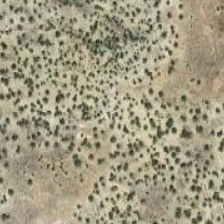

In [12]:
left = 4*224+112
low = 0*224+112
bbox = (left, low, left + 224, low + 224)
working_slice = img.crop(bbox)
working_slice

# Simple eval function

In [13]:
from PIL import Image
import torchvision.transforms.functional as TF

def transform_image(image):
    my_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    return my_transforms(image).unsqueeze(0)

def eval_simple(working_slice):
#     x = TF.to_tensor(working_slice)
#     x.unsqueeze_(0)
    x = transform_image(working_slice)
    output = model_read(x)
#     print(torch.softmax(output,1).detach().numpy().flatten())
#     print(output.detach().numpy().flatten())
    return output.detach().numpy().argmax()

eval_simple(working_slice)

0

# Score large map of DNM

<img src="data/DinosaurNationalMonument/Dinosaur National Monument Panorama.png" width="500"/>


In [18]:
import glob
from PIL import Image
from os.path import exists
import os
#path = "data/DinosaurNationalMonument/Dinosaur National Monument Panorama.png"
#path = "data/Test/GreenColorado.jpg"
#path = "data/Test/NMMystery1.jpg"
#path = "data/Test/MoabMillCreek.jpg"
img = Image.open(path).convert('RGB')

import time

from PIL import Image
countBuf = np.ones( (img.size[0], img.size[1]) )
sumBuf =   np.zeros( (img.size[0], img.size[1]) )

start = time.time()
step = 8  # choose a factor of 224: 1, 2, 4, 7, 8, 14, 16, 28, 32, 56, 112, and 224. Small is smooth map, large is fast
counts = {0:0, 1:0, 2:0}
scale = {0:0, 1:1, 2:1}
for x in tqdm(range(0, img.size[0]-224, step)):
    for y in range(0, img.size[1]-224, step):  
        bbox = (x, y, x + 224, y + 224)
        working_slice = img.crop(bbox)
        countBuf[bbox[0]:bbox[2], bbox[1]:bbox[3]] += 1
        sumBuf[bbox[0]:bbox[2], bbox[1]:bbox[3]] += scale[eval_simple(working_slice)]
print(f"step size = {step}, Elapsed: {(time.time() - start):6.1f} sec")


100%|██████████| 212/212 [03:33<00:00,  1.01s/it]

step size = 8, Elapsed:  213.3 sec


# Compute the mean of scores for sliding tiles

In [19]:
#set opacity to 159: 0 is transparent, 255 is opaque
meanBuf = sumBuf/countBuf
mat = np.uint8(meanBuf.T*159/meanBuf.max()) # scale the opacity: 0 transpartent, 255 solid
idx = mat < 0
mat[idx] = 0
output = Image.fromarray(mat)
output.save('results/bobTile.png')
np.save('results/meanBuf.npy', mat)

# NumPy Select: Color threshold differently

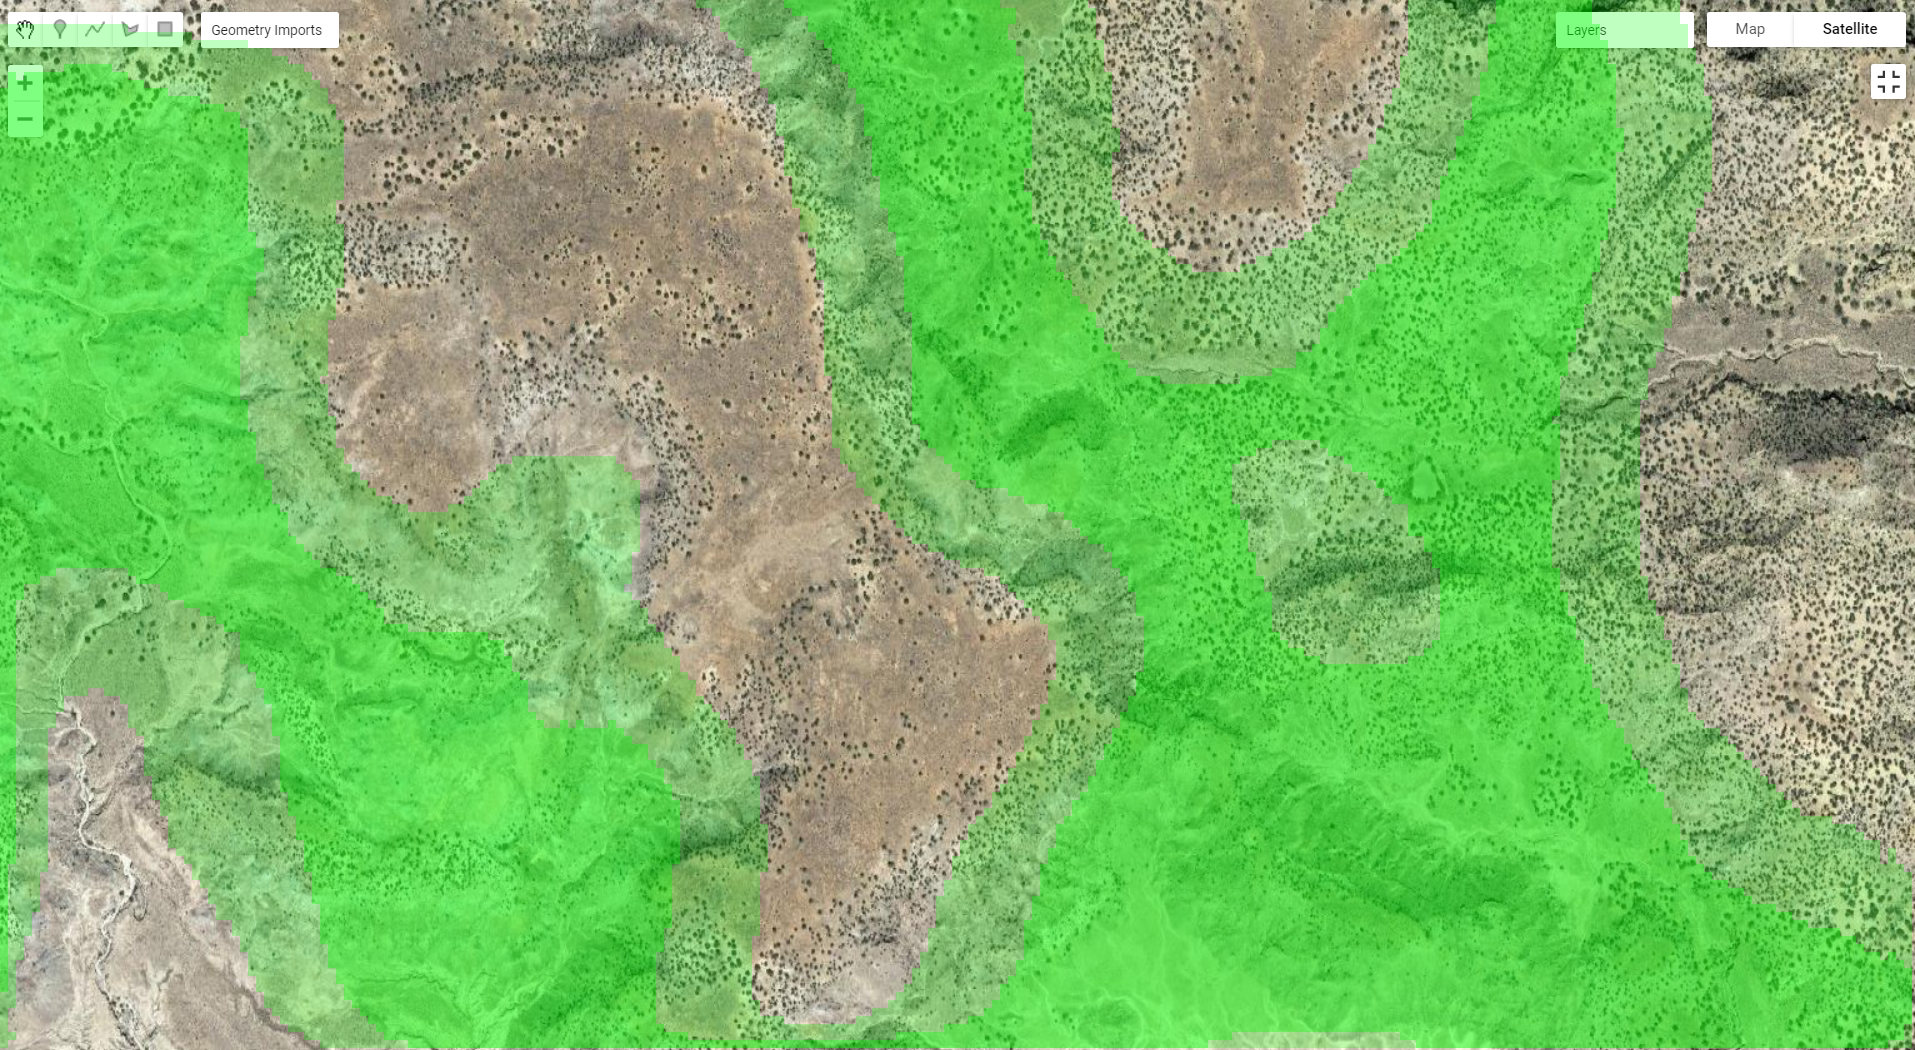

In [20]:
import time

from PIL import Image
#path = "data/DinosaurNationalMonument/Dinosaur National Monument Panorama.png"

img = Image.open(path)
alpha = np.uint8(meanBuf.T*159/meanBuf.max())
# lo = 60
# hi = 120
# condition = [ (alpha  < lo) ,
#               ( alpha >= lo) & (alpha < hi)]
# choice = [ 0, 
#            64 ]
# default = [(128)]

lo = 60
hi = 120
condition = [ (alpha  < lo) ,
              ( alpha >= lo) & (alpha < hi)]
choice = [ 0, 
           64 ]
default = [(128)]

newAlpha = np.select(condition, choice, default= default )
mask = Image.fromarray(newAlpha.astype('uint8'))
green = Image.new('RGBA',meanBuf.shape,(0,255,0,255))
img.paste(green, (0, 0), mask)
img.save('results/bobNewMapSelect.png')
img

# Heatmap Approach

Color Legend:
- Bright Red: Bones more likely
- Bright Blue: Bone not likely

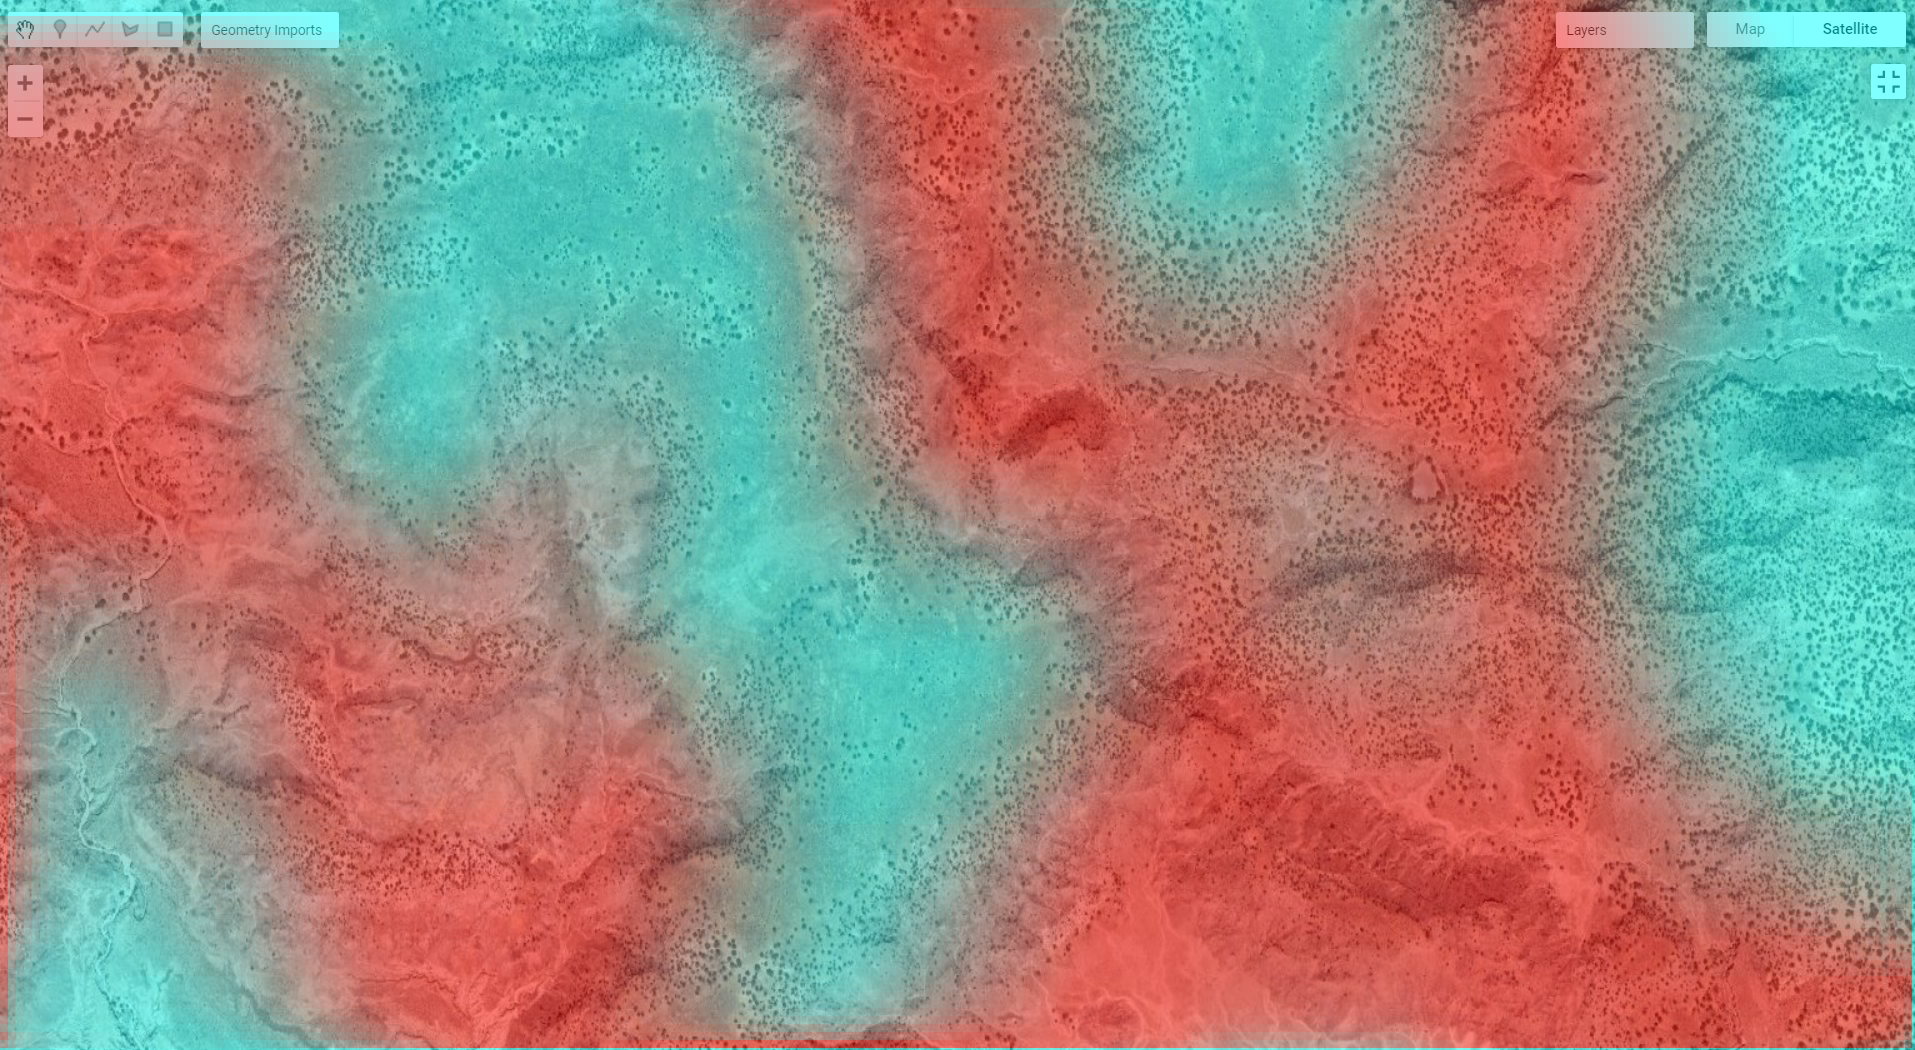

Color Legend:
- Red: Higher Probability
- Blue: -Lower Probability


In [21]:
from PIL import ImageDraw
import numpy as np

img = Image.open(path)
alpha = np.load('results/meanBuf.npy')

imgcv = Image.open(path.replace('.jpg','.PNG'))
heatmap_img = np.copy(imgcv)
alpha1D = alpha/alpha.max()*255

heatmap_img[:,:,0] = alpha1D
heatmap_img[:,:,1] = 255 - alpha1D
heatmap_img[:,:,2] = 255 - alpha1D

opacity = .5
imgHeat = Image.blend(Image.fromarray(heatmap_img), imgcv, alpha=0.5)
imgHeat.save('results/HeatMap.png')
imgHeat.show()
print("Color Legend:\n- Red: Higher Probability\n- Blue: -Lower Probability")